# SEGMENTATION DES CLIENTS AVEC LA METHODE K-MEANS

### 1-Importation des librairies

In [51]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr#pour calculer la matrice de correlation de pearson
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA #cette library permet de faire du machine leaning dans python
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer#pour la visualisation de la méthode du cloude qui est une extention de sklean

Les données que nous utiliserons proviennent de UCI Machine Learning. Elles comprennent les dépenses annuelles de différents types de produit de vente en détail(par exemple surgelés, épicerie, ect..)

In [66]:
#pip install -U yellowbrick
#compilez le commentaire ci-dessous pour installer yellowbrick

In [4]:
#importation des données
file=r'C:/Users/bc/Desktop/donnee vente/Wholesale customers data.csv'
data=pd.read_csv(file)

### 2-Chargeons les données

In [5]:
#afficher les 5 prmière lignes
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### 3-Analyse exploratoire des données

In [6]:
#je veux connaitre le type de distribution de la variable channel(le nombre de modalité)
data['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

<AxesSubplot:>

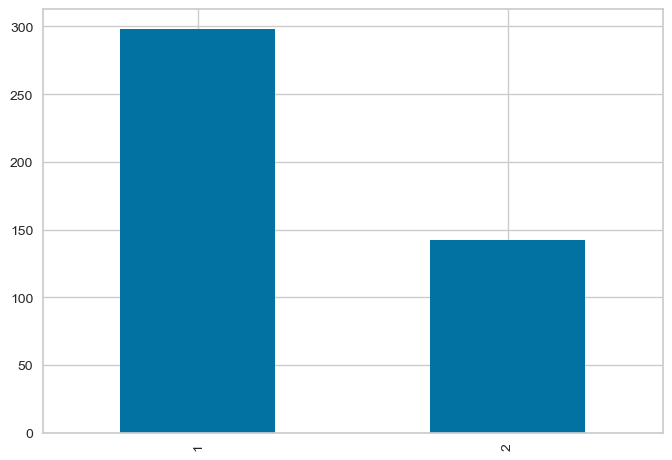

In [14]:
#Je peux faire un plot des deux modes de distribution
data['Channel'].value_counts().plot(kind='bar')

<AxesSubplot:>

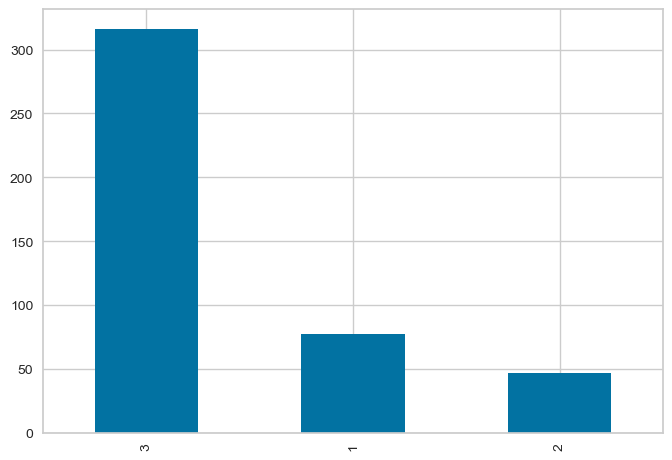

In [7]:
#Nous voulons avoir une idée sur la distribution des modalités des clients
data['Region'].value_counts().plot(kind='bar')

Il faut consulter la documentation des données afin de bien comprendre la signification des variables
:
https://archive.ics.uci.edu/ml/datasets/wholesale+customers

In [8]:
#on va changer le nom de certaines variables et de modalités
data=data.rename(columns={'Delicassen':'Delicatessen'})#Delicatessen:veut dire épiserie fine
data['Channel']=data['Channel'].map({1: 'HoReCa', 2: 'Retail'})#Retail: vente en détail
data['Region']=data['Region'].map({1: 'Lisbon', 2: 'Porto',3: 'Other'})#Retail: vente en détail

In [9]:
#table de fréquence de la variable région
data['Region'].value_counts()

Other     316
Lisbon     77
Porto      47
Name: Region, dtype: int64

In [10]:
#Les marchandises proviennent plus de la modalité other je veux normaliser donc mettre en pourcentage
data['Region'].value_counts(normalize=True)

Other     0.718182
Lisbon    0.175000
Porto     0.106818
Name: Region, dtype: float64

In [11]:
#Stockage des noms de colonnes de notre dataframe car nous allons l'utiliser après.la methode to list pour avoir une liste
features=data.columns.tolist()
features

['Channel',
 'Region',
 'Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicatessen']

In [12]:
#affichons le resummé statistique
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [13]:
#si je veux la structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel           440 non-null    object
 1   Region            440 non-null    object
 2   Fresh             440 non-null    int64 
 3   Milk              440 non-null    int64 
 4   Grocery           440 non-null    int64 
 5   Frozen            440 non-null    int64 
 6   Detergents_Paper  440 non-null    int64 
 7   Delicatessen      440 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 27.6+ KB


Nous ne voyons pas de valeurs manquantes dans les données

##### Visualisation des données

Créons actuellement un diagramme en bar et histogramme pour chaqu'une des variables nous utiliserons la boucle for

C:\Users\bc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


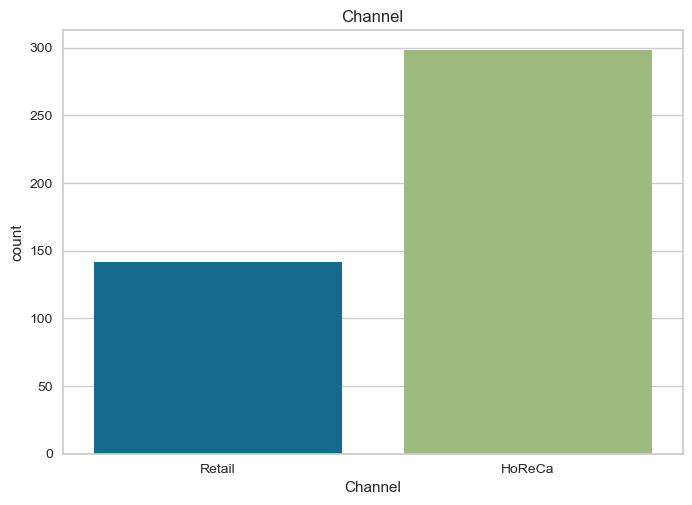

C:\Users\bc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


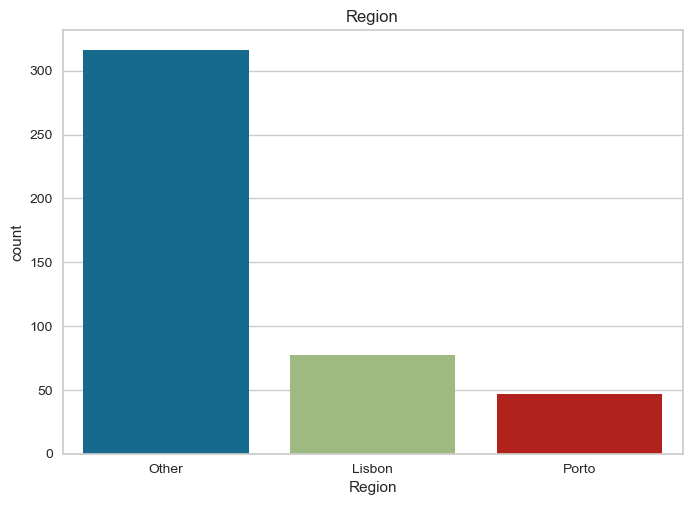

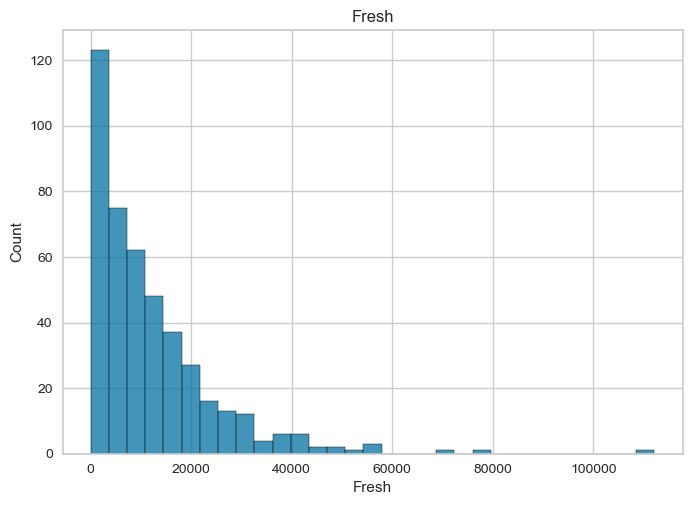

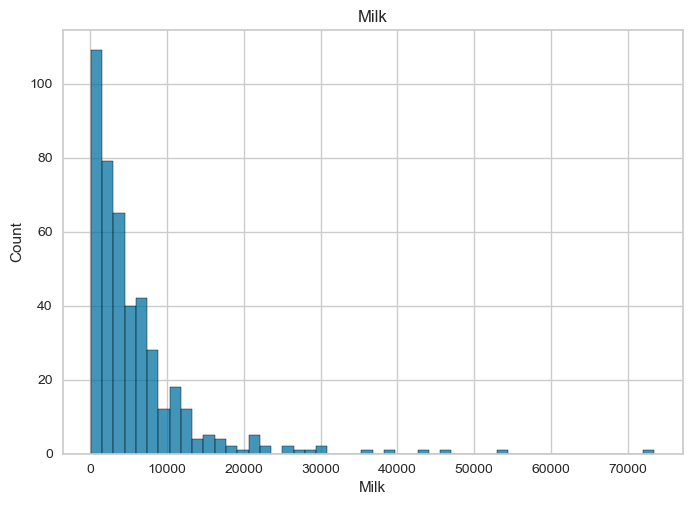

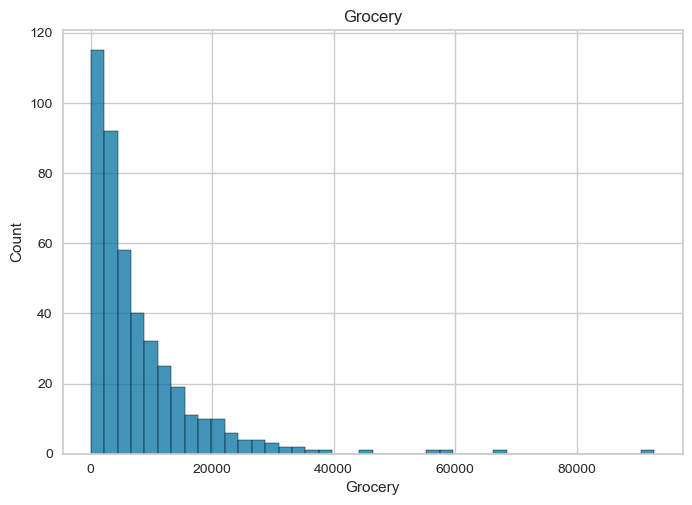

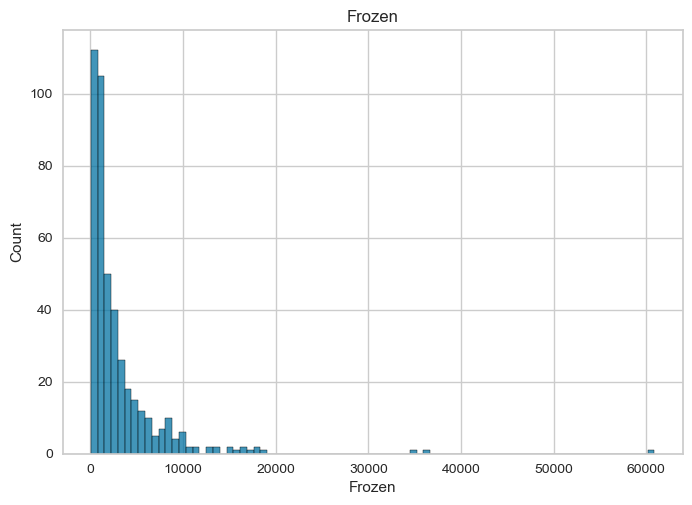

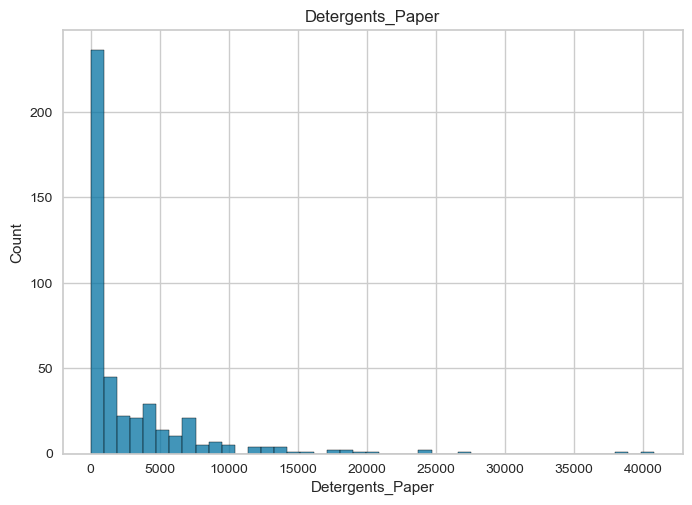

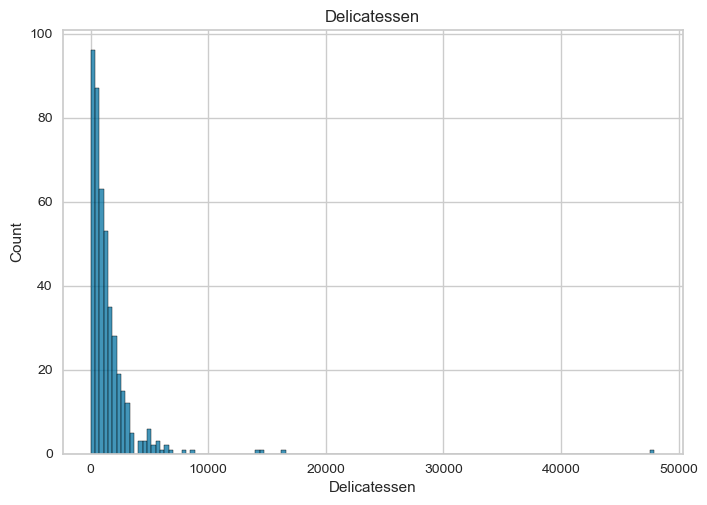

In [14]:
for feature in features:
    if(feature=='Channel')|(feature=='Region'):
        sns.countplot(data[feature]).set_title(feature)#count plot diagramme en bar
        plt.show()
    else:
        sns.histplot(data[feature]).set_title(feature)#histogramme
        plt.show()
        

On peut aussi utiliser une matrice de visualisation de seaborn

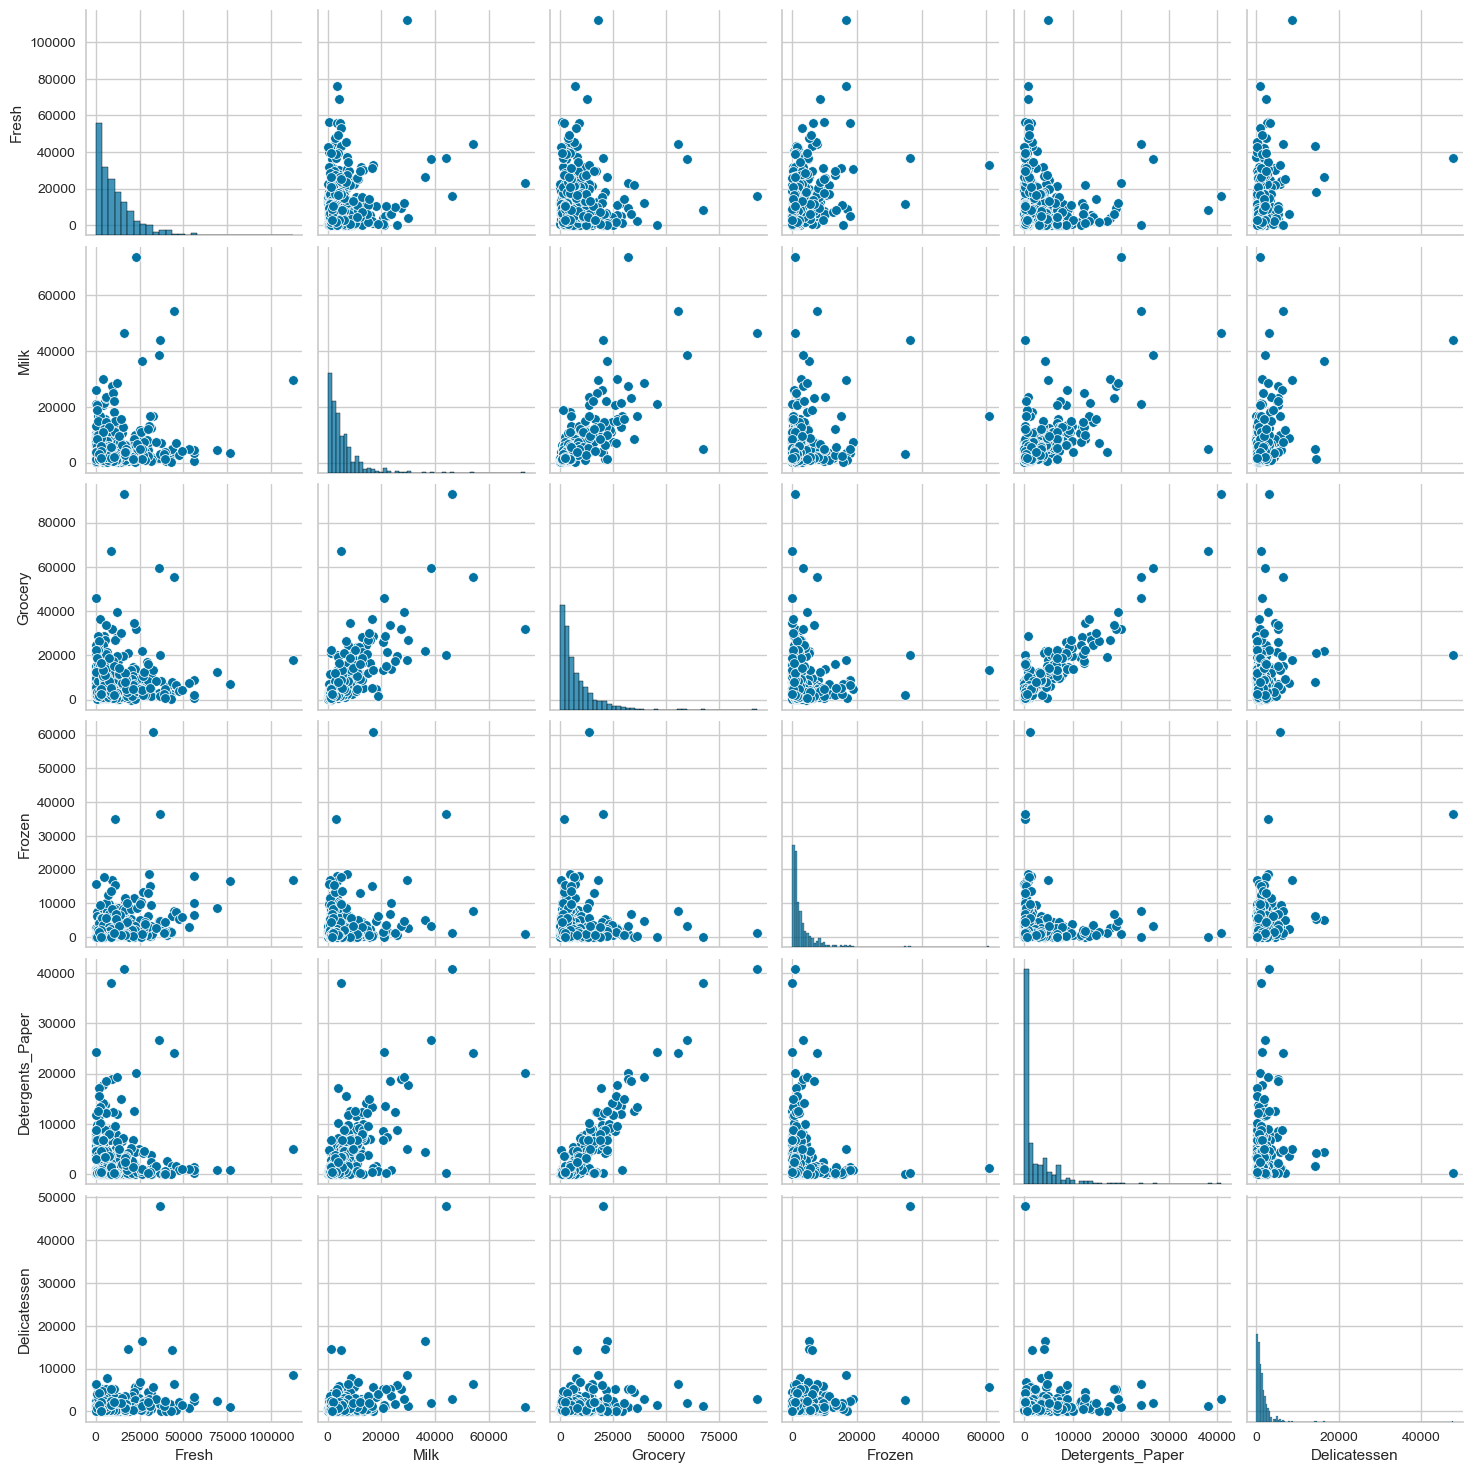

In [15]:
sns.pairplot(data)

Donc on voir que pour chaque pair de variable on a un nuage de point

### 4-ANALYSE EN COMPOSANTE PRINCIPAL ACP

##### 4-a) ACP LINEAIRE

Nous allons reduire la dimention de notre data frame à deux composantes principales afin de pouvoir visualiser les résultats dans un plan 2D

In [16]:
#commencons par supprimer les variables qualitatives des données Il s'agit de la variable channel et région
data2=data.drop(['Channel','Region'],axis=1)#ne pas oublier l'argument axis=1 pour signaler qu'il s'agit de colonne
data2

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


In [18]:
#l'ACP a besoin qu'on standardise  les données on doit les mettre sur le même echelle
scaler=StandardScaler()
data2=scaler.fit_transform(data2)
type(data2)

numpy.ndarray

In [19]:
data2

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

In [21]:
#appliquons l'ACP à deux composantes
pca=PCA(n_components=2)
res_pca=pca.fit_transform(data2)
type(res_pca)

numpy.ndarray

In [22]:
#affichage du résultat
res_pca

array([[ 1.93290546e-01, -3.05099963e-01],
       [ 4.34419896e-01, -3.28412623e-01],
       [ 8.11143234e-01,  8.15095701e-01],
       [-7.78647832e-01,  6.52753734e-01],
       [ 1.66287259e-01,  1.27143372e+00],
       [-1.56169932e-01, -2.95140988e-01],
       [-3.35288404e-01, -5.25003258e-01],
       [ 1.40586434e-01, -2.30992687e-01],
       [-5.17319541e-01, -6.59362827e-01],
       [ 1.59210908e+00, -7.41011332e-01],
       [ 6.38085945e-01, -4.01825201e-01],
       [-9.27692579e-01, -2.19287242e-01],
       [ 9.91362176e-01,  6.85910808e-01],
       [ 8.50246760e-01, -8.56919642e-02],
       [ 8.45043794e-01,  1.54724325e-01],
       [-9.51585375e-01, -4.95908498e-01],
       [ 5.57558717e-01, -1.02612272e+00],
       [-3.52538598e-01,  2.07075910e-01],
       [ 3.16578563e-01,  4.42066292e-01],
       [-3.23755737e-01, -7.03586946e-01],
       [-3.20000597e-01,  1.56628147e-01],
       [-1.11844720e+00, -2.30527519e-01],
       [-1.76694545e-01,  2.14371699e+00],
       [ 4.

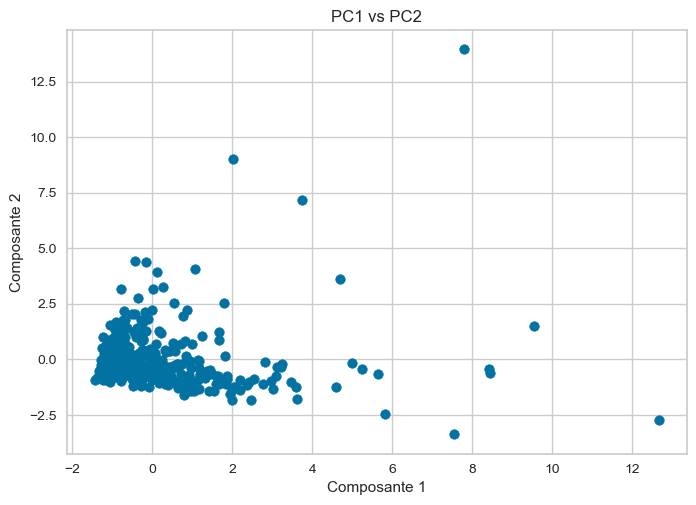

In [23]:
#visualisation des composantes principales
plt.scatter(res_pca[:,0],res_pca[:,1])
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("PC1 vs PC2")
plt.show()


In [24]:
#coefficient de corrélation de Pearson obtenu après ACP
pearsonr(res_pca[:,0],res_pca[:,1])

PearsonRResult(statistic=3.95516952522712e-16, pvalue=1.0000000000000955)

In [25]:
#Ajout des composantes principales au data frame initial
data['xpca']=res_pca[:,0]
data['ypca']=res_pca[:,1]


In [26]:
#Affichage des 5 premières lignes
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,xpca,ypca
0,Retail,Other,12669,9656,7561,214,2674,1338,0.193291,-0.305100
1,Retail,Other,7057,9810,9568,1762,3293,1776,0.434420,-0.328413
2,Retail,Other,6353,8808,7684,2405,3516,7844,0.811143,0.815096
3,HoReCa,Other,13265,1196,4221,6404,507,1788,-0.778648,0.652754
4,Retail,Other,22615,5410,7198,3915,1777,5185,0.166287,1.271434


#### 4-b)ACP NON LINEAIRE

In [52]:
#appliquons l'ACP à deux composantes
kpca=KernelPCA(n_components=2, kernel='rbf')
res_kpca=kpca.fit_transform(data2)
res_kpca

array([[ 7.83737059e-02, -1.73114604e-01],
       [ 1.85812546e-01, -3.07414714e-01],
       [ 3.41701538e-01,  7.50477517e-02],
       [-2.53303524e-01,  2.50352426e-01],
       [ 1.36616714e-01,  3.75279235e-01],
       [-8.89533043e-02, -2.12264712e-01],
       [-1.43530413e-01, -1.66305893e-01],
       [ 4.08969858e-02, -2.62715599e-01],
       [-2.20484030e-01, -3.05157788e-01],
       [ 7.08968837e-01, -2.91192502e-01],
       [ 3.19740641e-01, -3.06524578e-01],
       [-3.55451826e-01,  1.38748032e-02],
       [ 3.85446545e-01,  3.35728837e-01],
       [ 3.89500601e-01,  5.93738133e-02],
       [ 3.55511167e-01,  1.44217785e-01],
       [-3.54355200e-01, -1.10218594e-01],
       [ 3.22635645e-01, -4.72218998e-01],
       [-7.00024990e-02, -9.03504726e-02],
       [ 1.16541919e-01,  1.17853125e-01],
       [-1.20227554e-01, -2.83548201e-01],
       [-1.46900211e-01,  9.95711390e-02],
       [-3.99510714e-01, -9.26408202e-02],
       [ 2.04359988e-01,  6.35635926e-01],
       [ 3.

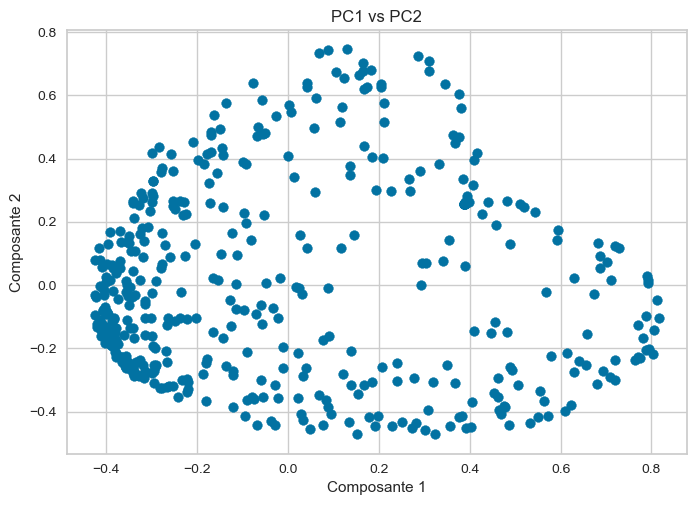

In [53]:
#visualisation des composantes principales
plt.scatter(res_kpca[:,0],res_kpca[:,1])
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("PC1 vs PC2")
plt.show()

**Nous voyons que l'ACP non lineaire donne un meilleur résultat. Nous allons l'utiliser dans la suite du travail**

### 5-Clustering K-MEANS avec la méthode du coude

In [54]:
#clustering avec 5 clusters on verra plus bas comment trouver le meilleur k
cluster_model=KMeans(n_clusters=5)
cluster_model.fit(res_kpca)#on applique le fit pour reduire on l'applique à l'ACP non lineaire
clusters=cluster_model.predict(res_kpca)#pour trouver les clusters du modèle

In [29]:
#affichage des clusters
clusters

array([4, 0, 1, 4, 1, 4, 4, 4, 4, 0, 0, 4, 1, 0, 0, 4, 0, 4, 1, 4, 4, 4,
       1, 2, 1, 4, 4, 4, 0, 1, 4, 4, 4, 1, 4, 0, 1, 0, 0, 1, 1, 4, 0, 0,
       0, 0, 0, 2, 0, 0, 4, 4, 1, 0, 4, 4, 2, 0, 4, 4, 4, 2, 4, 0, 4, 2,
       4, 0, 4, 4, 1, 1, 4, 1, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 2, 2, 1,
       4, 1, 4, 1, 2, 1, 0, 4, 4, 4, 4, 4, 0, 0, 4, 1, 4, 4, 0, 0, 4, 0,
       4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 0, 4, 0, 0, 0, 4, 4, 0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 0, 4, 0,
       1, 4, 4, 4, 4, 3, 0, 3, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 4, 1, 1, 0,
       4, 4, 0, 0, 1, 4, 4, 0, 4, 4, 4, 0, 4, 2, 4, 4, 0, 0, 0, 4, 0, 4,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4,
       4, 4, 0, 0, 4, 4, 4, 4, 4, 2, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4,
       0, 1, 0, 1, 0, 4, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4, 1, 1, 1, 4,
       4, 1, 4, 1, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4,

Nous avons 5 clusters numéroter de 0 à 4

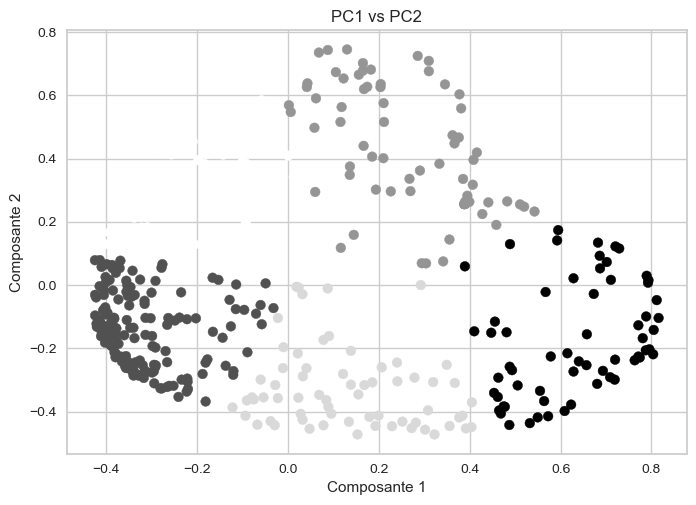

In [55]:
#visualiser les clusters
#visualisation des composantes principales
plt.scatter(res_kpca[:,0],res_kpca[:,1],c=clusters)#on ajoute un seul argument au code d'en haut
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("PC1 vs PC2")
plt.show()


**Comment déterminer le meilleur k** nous verons celà dans la suite

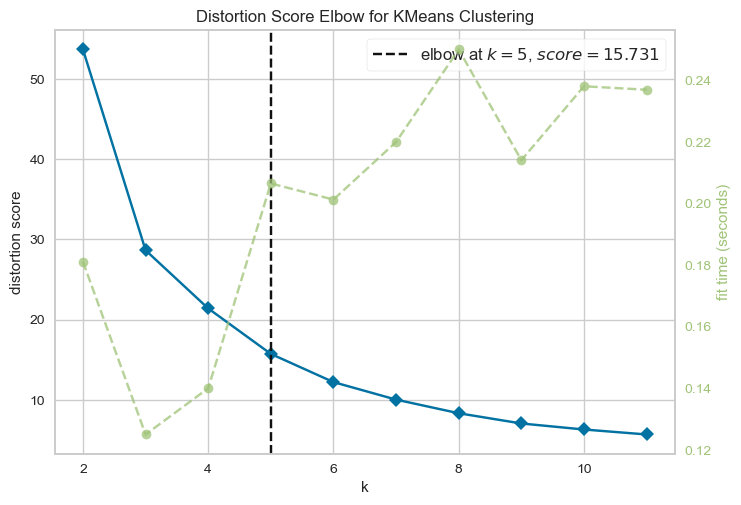

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
#methode de cloude
kmeans=KMeans()
visualiseur=KElbowVisualizer(kmeans,k=(2,12))#je. lui dis que k se trouver entre 2 et 12
visualiseur.fit(res_kpca)
visualiseur.show()

Nous voyons que le meilleur k est 5 et que le Kmeans est moins efficasse au fure et à mesure que k augmente

In [57]:
#ajout des clusters aux data frame et sauvegarde de fichier
data['cluster_pca']=clusters
data.to_csv('data_with_cluster.csv')#on enregistre le contenu dans un fichier csv et on peut partager notre fichier avec les clusters

##### les clusters étant déterminés, il faudrait les interpreter

### 6-ANALYSONS ACTUELLEMENT LES RESULTATS

Analysons donc la segmentation

In [58]:
#on peut charger le fichier précedement enregistré
dataframe=pd.read_csv('data_with_cluster.csv',index_col=0)

In [59]:
#observons les 5 premières lignes
dataframe.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,xpca,ypca,cluster_pca
0,Retail,Other,12669,9656,7561,214,2674,1338,0.193291,-0.305100,1
1,Retail,Other,7057,9810,9568,1762,3293,1776,0.434420,-0.328413,1
2,Retail,Other,6353,8808,7684,2405,3516,7844,0.811143,0.815096,2
3,HoReCa,Other,13265,1196,4221,6404,507,1788,-0.778648,0.652754,0
4,Retail,Other,22615,5410,7198,3915,1777,5185,0.166287,1.271434,2


In [60]:
dataframe['cluster_pca'].unique()

array([1, 2, 0, 3, 4], dtype=int64)

Chaque cluster a un représentant donc les caractéristiques sont les caractéristiques moyenne du groupe

#### Centroides

Nous cherchons les caractéristiques moyennes du groupe
rappelons la variables features avec le nom des variables originelle

In [61]:
features

['Channel',
 'Region',
 'Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicatessen']

In [62]:
dataframe.groupby('cluster_pca')[features].mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
cluster_pca,,,,,,
0,17442.426829,2352.609756,3127.085366,4284.304878,552.853659,1120.890244
1,5010.815385,6713.061538,9540.538462,1217.676923,3856.338462,1197.492308
2,29583.671233,11270.945205,12885.630137,7836.178082,4528.547945,3681.082192
3,6534.196203,2390.000000,2992.044304,1676.056962,695.386076,844.031646
4,5357.064516,11624.112903,19493.741935,1360.161290,8571.064516,1598.661290


On peut aussi integrer les variables 'Channel' et 'Région'

In [63]:
dataframe.groupby(['cluster_pca','Channel','Region'])[features].mean()

Fresh          Milk       Grocery  \
cluster_pca Channel Region                                             
0           HoReCa  Lisbon  16912.176471   1504.000000   2178.823529   
                    Other   17779.083333   2372.166667   2852.208333   
                    Porto   17039.636364   1979.818182   3843.454545   
            Retail  Lisbon  15927.000000   5955.000000   7413.500000   
                    Other   17521.500000   4948.500000   6342.500000   
1           HoReCa  Lisbon   3218.333333   7438.166667   7476.500000   
                    Other    3332.312500   5690.250000   8992.187500   
            Retail  Lisbon   2443.333333   6128.333333   9281.333333   
                    Other    6374.567568   7013.243243  10133.918919   
                    Porto    3295.666667   7600.333333   9534.000000   
2           HoReCa  Lisbon  31168.666667   9313.333333   7786.666667   
                    Other   34887.564103   6569.153846   5962.948718   
                    Porto   16360.000000   8558.500000  10323.500000   
            Retail  Lisbon   9126.500000  25729.500000  36640.000000   
                    Other   23057.333333  22303.388889  25736.555556   
                    Porto   17490.000000   4241.666667  26943.666667   
3           HoReCa  Lisbon   6580.461538   2444.615385   2693.269231   
                    Other    6010.603774   2296.632075   2613.669811   
                    Porto    7070.600000   1708.266667   4009.933333   
            Retail  Lisbon   2790.000000   2527.000000   5265.000000   
                    Other   11887.428571   4446.714286   5953.571429   
                    Porto   10708.666667   3779.666667   6193.333333   
4           HoReCa  Lisbon   2806.000000  10765.000000  15538.000000   
                    Other   11908.500000  15602.500000  14858.000000   
            Retail  Lisbon   3337.300000  10983.100000  21127.900000   
                    Other    5849.205128  11311.128205  19740.820513   
                    Porto    4402.300000  12776.000000  18218.700000   

                                  Frozen  Detergents_Paper  Delicatessen  
cluster_pca Channel Region                                                
0           HoReCa  Lisbon   3719.529412        289.588235   1137.647059  
                    Other    4409.145833        512.312500   1024.000000  
                    Porto    4963.727273        505.000000   1198.000000  
            Retail  Lisbon   5040.000000       1761.500000   1845.000000  
                    Other    2940.250000       1685.500000   1638.250000  
1           HoReCa  Lisbon   1071.666667       2718.500000    960.000000  
                    Other    1080.687500       3090.312500   1139.812500  
            Retail  Lisbon   1662.000000       5195.666667    793.000000  
                    Other    1306.621622       4179.351351   1342.108108  
                    Porto     699.000000       4894.333333    601.000000  
2           HoReCa  Lisbon   7238.666667        739.444444   2997.555556  
                    Other    9338.282051        859.282051   3836.794872  
                    Porto   38235.000000        643.500000   3079.500000  
            Retail  Lisbon   5741.000000      19002.000000   3995.500000  
                    Other    2316.277778      11587.833333   3950.888889  
                    Porto    4351.666667      14181.666667   2280.000000  
3           HoReCa  Lisbon   1858.769231        860.153846    621.769231  
                    Other    1619.877358        500.764151    908.679245  
                    Porto    1986.000000        444.933333    775.200000  
            Retail  Lisbon   5612.000000        788.000000   1360.000000  
                    Other     954.857143       2626.000000    727.571429  
                    Porto     898.666667       2860.666667    930.000000  
4           HoReCa  Lisbon   1374.000000       5828.000000   2388.000000  
                    Other    3388.000000       2680.500000   3507.00000

La cellule marketing pourra grâce à ceci mieux planifier sa campagne

Interessons nous à la variable région

In [64]:
dataframe.groupby(['cluster_pca','Region'])[features].mean()

Fresh          Milk       Grocery        Frozen  \
cluster_pca Region                                                           
0           Lisbon  16808.473684   1972.526316   2729.842105   3858.526316   
            Other   17759.269231   2570.346154   3120.692308   4296.153846   
            Porto   17039.636364   1979.818182   3843.454545   4963.727273   
1           Lisbon   2960.000000   7001.555556   8078.111111   1268.444444   
            Other    5456.150943   6613.849057   9789.245283   1238.415094   
            Porto    3295.666667   7600.333333   9534.000000    699.000000   
2           Lisbon  27161.000000  12298.090909  13032.727273   6966.363636   
            Other   31151.701754  11537.859649  12207.245614   7120.807018   
            Porto   17038.000000   5968.400000  20295.600000  17905.000000   
3           Lisbon   6440.074074   2447.666667   2788.518519   1997.777778   
            Other    6374.654867   2429.823009   2820.566372   1578.681416   
            Porto    7676.944444   2053.500000   4373.833333   1804.777778   
4           Lisbon   3289.000000  10963.272727  20619.727273   1429.818182   
            Other    6144.780488  11520.463415  19502.634146   1394.609756   
            Porto    4402.300000  12776.000000  18218.700000   1142.300000   

                    Detergents_Paper  Delicatessen  
cluster_pca Region                                  
0           Lisbon        444.526316   1212.105263  
            Other         602.557692   1071.250000  
            Porto         505.000000   1198.000000  
1           Lisbon       3544.222222    904.333333  
            Other        3850.584906   1281.037736  
            Porto        4894.333333    601.000000  
2           Lisbon       4059.909091   3179.000000  
            Other        4247.245614   3872.824561  
            Porto        8766.400000   2599.800000  
3           Lisbon        857.481481    649.111111  
            Other         632.415929    897.460177  
            Porto         847.555556    801.000000  
4           Lisbon       8725.545455   1878.454545  
            Other        8327.804878   1618.195122  
            Porto        9398.500000   1210.800000